<a href="https://colab.research.google.com/github/champsleague/Machine-Learning-Projects/blob/main/ML_Recommendation_System_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Movie recommendation

Our Business Objective is to make Movie Recommendation System by using user’s data
The System filters and predicts movies that corresponds to user’s favor.
It’s a system for people who are thinking about which movie to choose

<img src = "https://drive.google.com/file/d/1uujYgF7tM7P9lEd8JqX23JhzPk6BpF7j" height = 300 width = 300>

Data Information
We used 2 datasets to make recommendation & test system
Main Dataset is ‘TMDB 5000 Movie Dataset’ 
Test Dataset is ‘The Movies Dataset’


In [ ]:
import io
import pandas as pd
import numpy as np

# no change
df=pd.read_csv('tmdb_5000_credits.csv')
df

reduced data (4803 rows→ 1493 rows)
df=pd.read_csv('tmdb_5000_movies.csv')
df = df.replace('', np.nan)
df.dropna()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [ ]:
# matrix factorization

import pandas as pd
import numpy as np
movies = pd.read_csv("tmdb_5000_movies.csv")         
movies = movies[["id","genres","vote_average","vote_count","popularity","original_title", "keywords","overview"]]
movies.drop(["genres","vote_average","vote_count","popularity", "keywords","overview"],axis=1,inplace=True)

print(movies.shape)
movies.head()

movies.columns = ['tmdbId', 'original_title']
movies.head()

links = pd.read_csv("links_small.csv")
links = links[["movieId","imdbId","tmdbId"]]
links.drop(['imdbId'],axis=1,inplace=True)
print(links.shape)
links.head()

ratings = pd.read_csv("ratings_small.csv")   
ratings = ratings[["userId","movieId","rating","timestamp"]]
ratings.drop(["timestamp"],axis=1,inplace=True)
print(ratings.shape)
ratings.head()

links = links.dropna(axis=0)
links["tmdbId"] = links["tmdbId"].astype("int")
links.head()

# innerjoin dataframes
join_movie = pd.merge(ratings, links, left_on='movieId', right_on='movieId', how='inner')
print(join_movie)

join_movie = pd.merge(join_movie, movies, left_on='tmdbId', right_on='tmdbId', how='inner')
print(join_movie)

# Create PivotTable
user_movie_rating = join_movie.pivot_table('rating', index = 'userId', columns='tmdbId').fillna(0)
print(user_movie_rating.shape)
user_movie_rating.head()


# Find a non-zero partial index of the source matrix
data = user_movie_rating.values

nonZeroX=[]
nonZeroY=[]

for i in range (0, data.shape[0]):
  for j in range(0, data.shape[1]):
    # print(mat[i][j])
    if (data[i][j] != 0):
      nonZeroX.append(i)
      nonZeroY.append(j)


# Find nonzero partial values in the source matrix
nonZeroData = []
for i,j in zip (nonZeroX, nonZeroY):
  nonZeroData.append(data[i][j])


# Learning RMSE
from sklearn.metrics import mean_squared_error

num_users, num_items = user_movie_rating.shape
K = 150

np.random.seed(1)
P = np.random.normal(scale=1.0/K, size=(num_users, K))
Q = np.random.normal(scale=1.0/K, size=(num_items, K))

# revise not to overfit
r_lambda = 0.03

# learning rate
lr = 0.02

# steps iteration
step = 100

for epoch in range(1, step+1):
  for i,j in zip (nonZeroX, nonZeroY):
    error = data[i][j] - np.dot(P[i, :], Q[j, :].T)
    
    # Correct P, Q matrix using SGD based on obtained error
    P[i, :] = P[i, :] + lr*(error * Q[j, :] - r_lambda*P[i, :])
    Q[j, :] = Q[j, :] + lr*(error * P[i, :] - r_lambda*Q[j, :])


  # Predict based on corrected matrix
  prediction = np.dot(P, Q.T)
  errorList = []

  # Gets the values in the source matrix that are in the nonzero
  for i,j in zip (nonZeroX, nonZeroY):
    errorList.append(prediction[i][j])

  if (epoch) % 10 == 0:
      # error calculation
      rmse = mean_squared_error(nonZeroData, errorList, squared=False)
      print("epoch: {}, rmse: {:.6f}" .format(epoch, rmse))


# Check the predicted matrix
pred_matrix = np.dot(P, Q.T)
pred_matrix_df = 
pd.DataFrame(pred_matrix, columns = user_movie_rating.columns, index = user_movie_rating.index)
print(pred_matrix_df.shape)
pred_matrix_df.head()


# Check in 0.5 point 
thres = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

for i in range(0, pred_matrix.shape[0]):
  for j in range(0, pred_matrix.shape[1]):
    for k in thres:
      if pred_matrix[i][j] < 0:
        pred_matrix[i][j] = 0.0
        break
      elif pred_matrix[i][j] > 5.0:
        pred_matrix[i][j] = 5.0
        break      
      elif (pred_matrix[i][j]>= k-0.25) and (pred_matrix[i][j]< k+0.25):
        pred_matrix[i][j] = k
        break


pred_matrix_df_05 = pd.DataFrame(pred_matrix, columns = user_movie_rating.columns, index = user_movie_rating.index)
print(pred_matrix_df_05.shape)
pred_matrix_df_05.head()  

(4803, 2)
(9125, 2)
(100004, 3)
       userId  movieId  rating  tmdbId
0           1       31     2.5    9909
1           7       31     3.0    9909
2          31       31     4.0    9909
3          32       31     4.0    9909
4          36       31     3.0    9909
...       ...      ...     ...     ...
99928     664    64997     2.5   34812
99929     664    72380     3.5   22825
99930     665      129     3.0  110972
99931     665     4736     1.0   26602
99932     668     6425     1.0   36807

[99933 rows x 4 columns]
       userId  movieId  rating  tmdbId  original_title
0           1     1061     3.0     819        Sleepers
1          19     1061     3.0     819        Sleepers
2          23     1061     3.5     819        Sleepers
3          30     1061     3.0     819        Sleepers
4          70     1061     5.0     819        Sleepers
...       ...      ...     ...     ...             ...
66942     663   134528     3.5  222936           Aloha
66943     663   137595     3.0  26

tmdbId,5,11,12,13,14,16,18,19,20,22,...,325173,328111,328425,329833,332411,332567,333371,334074,342521,347969
userId,,,,,,,,,,,,,,,,,,,,,
1,2.0,2.0,2.5,3.0,3.0,2.0,3.0,2.5,3.0,2.5,...,1.5,2.0,2.0,1.5,1.0,1.5,3.0,1.5,0.5,1.5
2,2.5,4.0,3.5,3.0,4.0,3.5,3.0,4.0,4.0,3.0,...,2.0,3.0,3.0,2.0,1.0,2.0,4.0,2.5,0.5,2.0
3,4.0,4.0,3.0,5.0,4.0,3.5,3.5,3.0,3.5,3.0,...,2.5,3.0,2.5,2.0,1.0,2.0,4.0,2.5,0.5,2.0
4,4.0,5.0,5.0,5.0,4.5,4.5,4.5,5.0,4.5,4.5,...,3.0,3.5,3.0,2.5,1.5,2.5,5.0,3.0,0.5,2.0
5,3.5,4.0,4.0,4.0,3.5,3.5,3.5,3.0,4.0,4.0,...,2.5,4.0,3.0,2.5,1.0,2.0,4.5,2.5,0.5,2.0


Estimated number of clusters: 37
Estimated number of noise points: 61


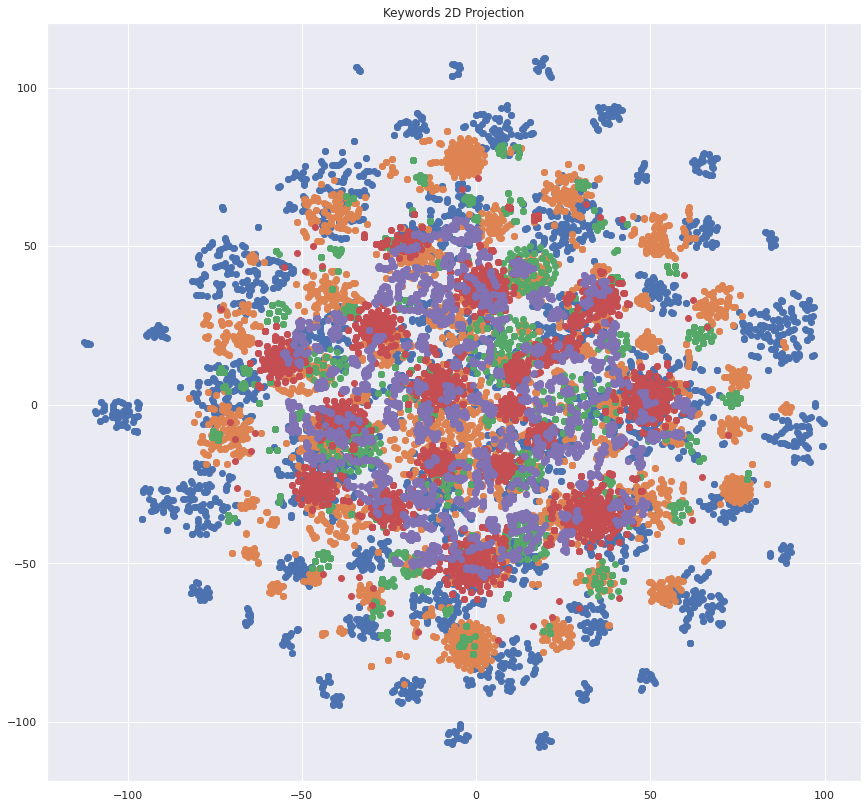

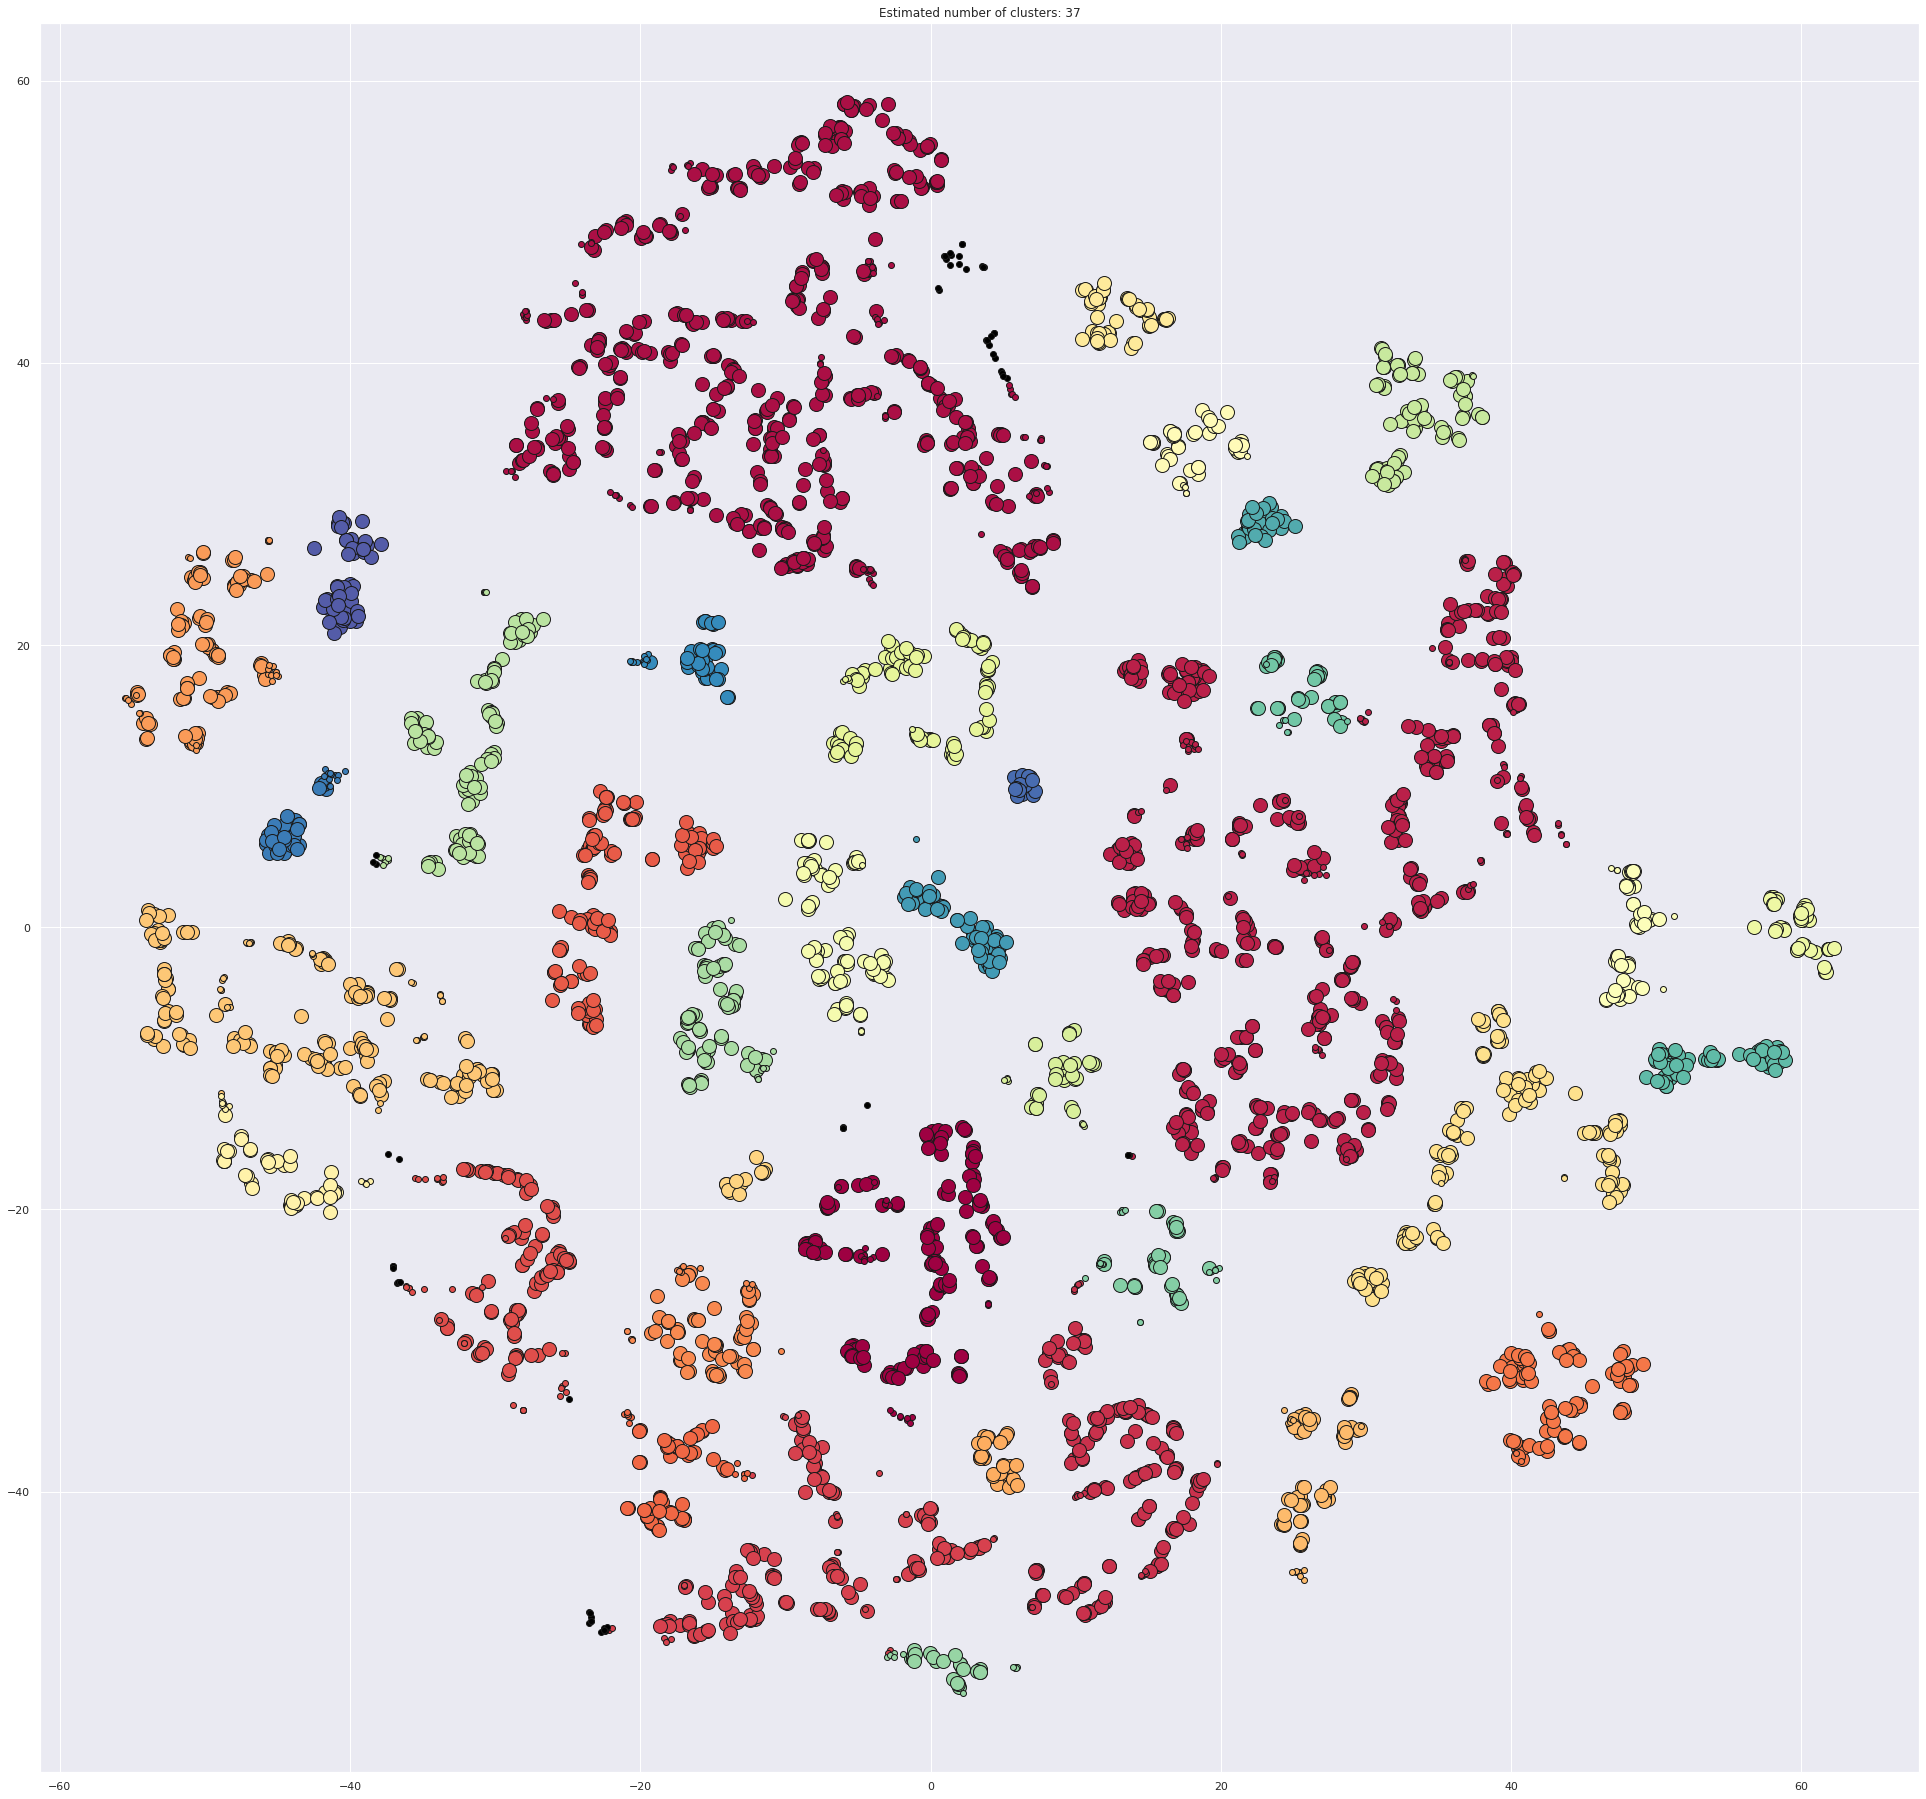

In [ ]:
import os
import json
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

credits = pd.read_csv("tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb_5000_movies.csv")

dataframe = pd.DataFrame()
dataframe["id"] = movies["id"] # reference
dataframe["title"] = movies["title"] # text
dataframe["year"] = [x[:4] for x in np.array(movies["release_date"].values.tolist())] # z
dataframe["popularity"] = movies["popularity"] # size
dataframe["genres"] = [json.loads(x) for x in np.array(movies["genres"].values.tolist())] # color
dataframe["crew"] = [json.loads(x) for x in np.array(credits["crew"].values.tolist())] # x / y
dataframe["cast"] = [json.loads(x) for x in np.array(credits["cast"].values.tolist())] # x / y
dataframe["keywords"] = [json.loads(x) for x in np.array(movies["keywords"].values.tolist())]
dataframe['rating'] = movies['vote_average']

dataframe = dataframe.iloc[np.where(dataframe['year'] != "")[0]]
dataframe = dataframe.iloc[np.where(dataframe['genres'])[0]]
dataframe = dataframe.iloc[np.where(dataframe['crew'])[0]]
dataframe = dataframe.iloc[np.where(dataframe['cast'])[0]]
dataframe = dataframe.iloc[np.where(dataframe['keywords'])[0]]

dataframe


num_genres = 2
num_keywords = 20
num_cast = 50
num_crew = 50

# Encode numerical ids into strings
def encode(array, length, suffix):
    encoded = np.zeros(shape=(array.shape[0], length), dtype='<U10')
    for i, row in enumerate(array):
        encoded[i,:len(row)] = [str(x['id']) + suffix for x in row][:length]
    return encoded

cast_encoded = encode(dataframe['cast'], num_cast, 'ca')
crew_encoded = encode(dataframe['crew'], num_crew, 'cr')
genres_encoded = encode(dataframe['genres'], num_genres, 'ge')
keywords_encoded = encode(dataframe['keywords'], num_keywords, 'kw')

keywords_encoded

enc = OneHotEncoder()
cast_one_hot = enc.fit_transform(cast_encoded)

svd = TruncatedSVD(n_components=20)
svd_result = svd.fit_transform(cast_one_hot)

cast_tsne = TSNE(random_state=0, learning_rate=200, perplexity=5).fit_transform(svd_result)
plt.title("Cast 2D Projection")
plt.scatter(cast_tsne[:,0], cast_tsne[:,1])


enc = OneHotEncoder()
crew_one_hot = enc.fit_transform(crew_encoded)

svd = TruncatedSVD(n_components=50)
svd_result = svd.fit_transform(crew_one_hot)

crew_tsne = TSNE(random_state=0, learning_rate=50, perplexity=5).fit_transform(svd_result)
plt.title("Crew 2D Projection")
plt.scatter(crew_tsne[:,0], crew_tsne[:,1])
            
          
enc = OneHotEncoder()
genres_one_hot = enc.fit_transform(genres_encoded)

svd = TruncatedSVD(n_components=10)
svd_result = svd.fit_transform(genres_one_hot)

genres_tsne = TSNE(random_state=0, learning_rate=50, perplexity=30).fit_transform(svd_result)
plt.title("Genres 2D Projection")
plt.scatter(genres_tsne[:,0], genres_tsne[:,1])


enc = OneHotEncoder()
keywords_one_hot = enc.fit_transform(keywords_encoded)

svd = TruncatedSVD(n_components=100)
svd_result = svd.fit_transform(keywords_one_hot)

keywords_tsne = TSNE(random_state=0, learning_rate=50, perplexity=30).fit_transform(svd_result)
plt.title("Keywords 2D Projection")
plt.scatter(keywords_tsne[:,0], keywords_tsne[:,1])


one_matrix = np.concatenate((keywords_tsne, genres_tsne), axis=1)
one_tsne = TSNE(random_state=0, learning_rate=30, perplexity=40, early_exaggeration=60).fit_transform(one_matrix)
plt.scatter(one_tsne[:, 0], one_tsne[:, 1])



# Applying DBSCAN clustering
db = DBSCAN(eps=3.5, min_samples=20).fit(one_tsne)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
plt.figure(figsize=(30, 30))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = one_tsne[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = one_tsne[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

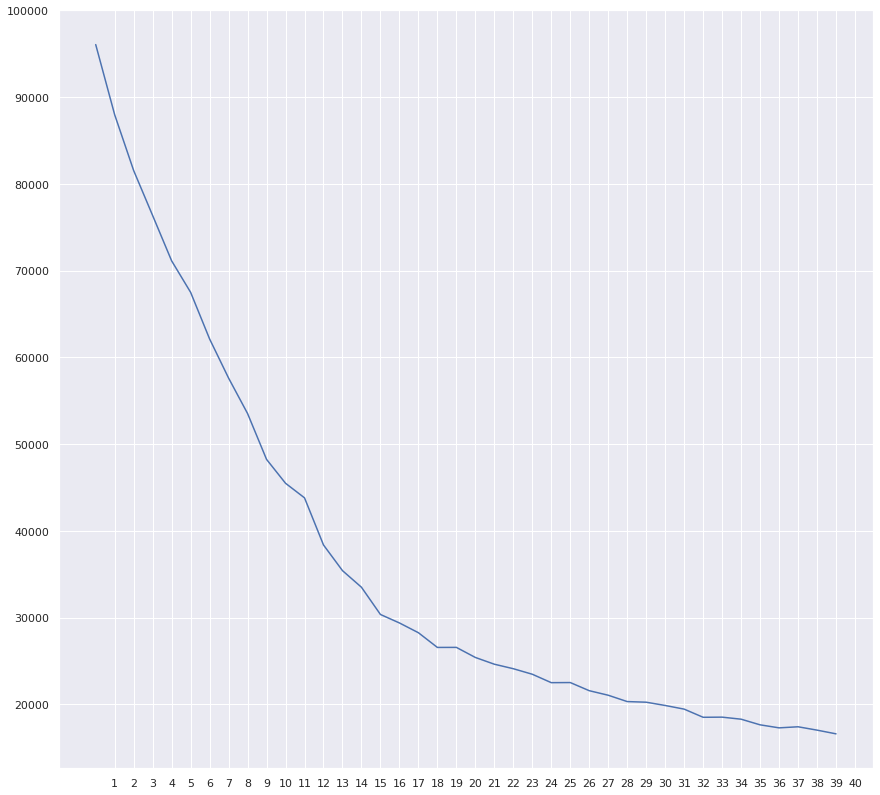

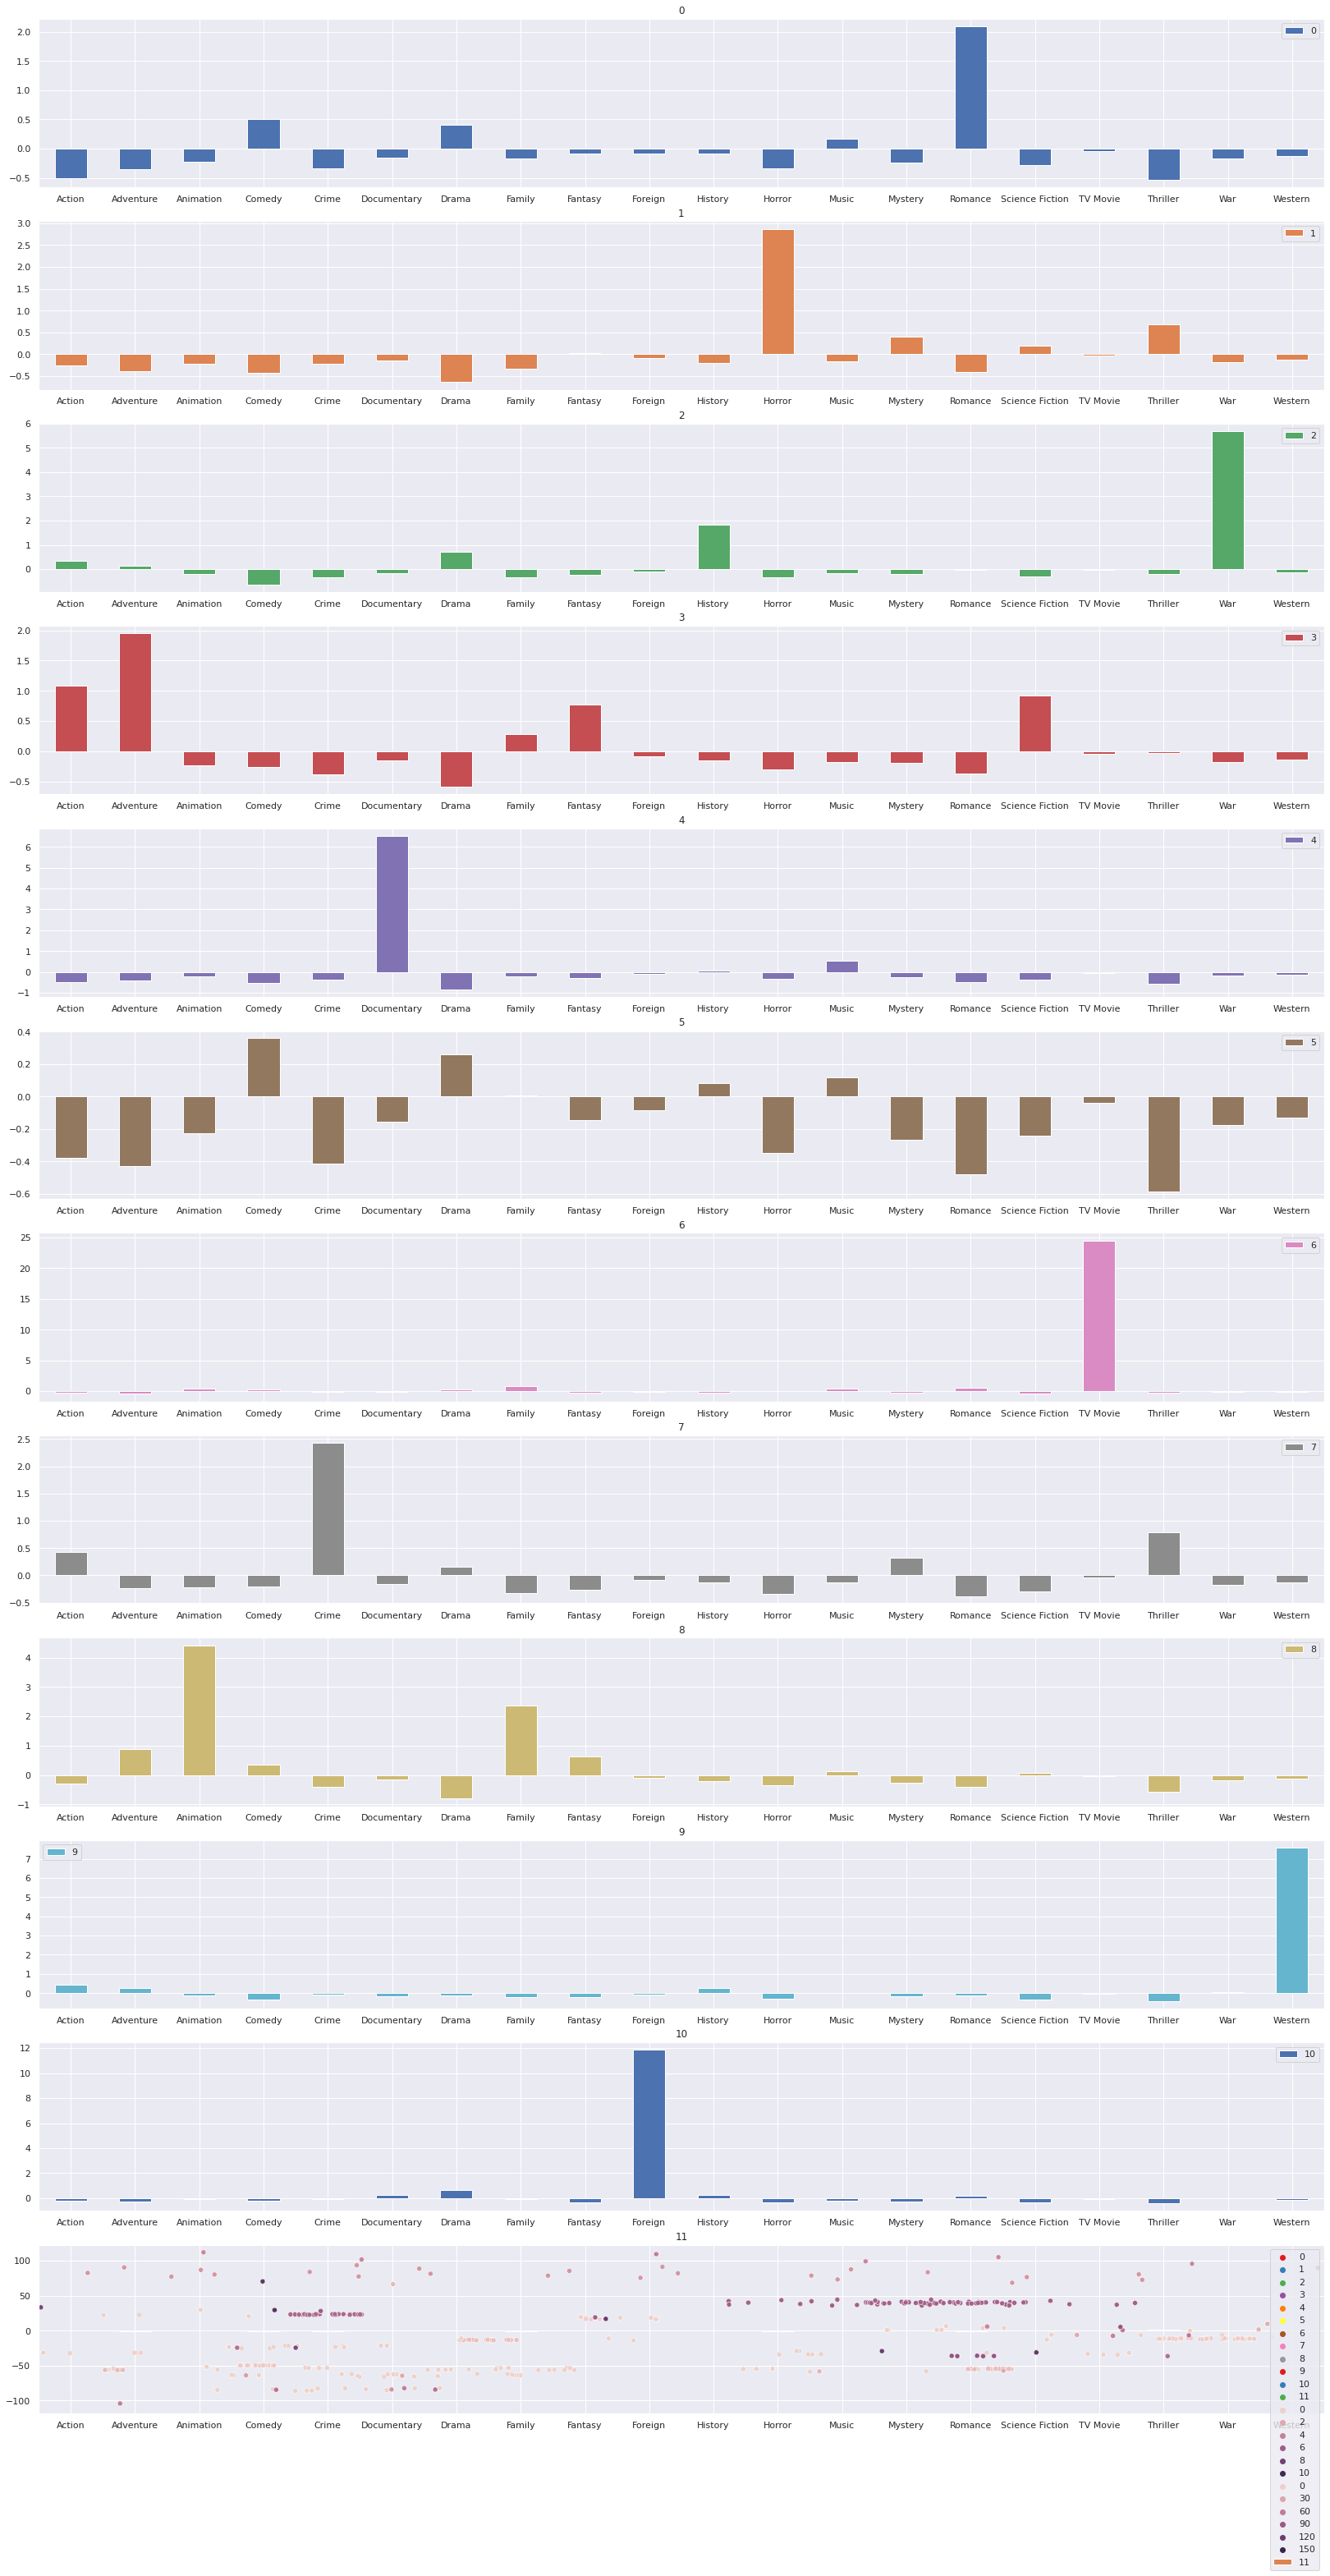

In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

np.random.seed(42)

def extract_genres(data, key='name', separator='|'):
    elements = json.loads(data)
    targets = []
    for element in elements:
        targets.append(element[key])
    return separator.join(targets)


df = pd.read_csv('tmdb_5000_movies.csv')
df['genres'] = df['genres'].apply(extract_genres)
df.head()

genres = df['genres'].str.get_dummies()
genres.head()


standard_scaler = StandardScaler()
scaled_genres = standard_scaler.fit_transform(genres)
genres[genres.columns] = scaled_genres

movies = pd.concat([df['original_title'], genres], axis=1)

movies[movies['original_title'].isin(['Toy Story', 'Inception', 'Avatar'])]

def kmeans(n_clusters, genres):
    model = KMeans(n_clusters=n_clusters)
    model.fit(genres)
    return [n_clusters, model.inertia_]

elbow_data = [kmeans(n_clusters, scaled_genres) for n_clusters in range(1, 41)]
elbow_data = pd.DataFrame(elbow_data, columns=['clusters', 'inertia'])

elbow_data['inertia'].plot(xticks=elbow_data['clusters'])

model = KMeans(n_clusters=12)
model.fit(scaled_genres)

genres_groups = pd.DataFrame(model.cluster_centers_, columns=genres.columns)
genres_groups

genres_groups.transpose().plot.bar(
    subplots=True,
    figsize=(25,50),
    sharex=False,
    rot=0)

df[model.labels_ == 0].head()

tsne = TSNE()
reduced_genres = tsne.fit_transform(scaled_genres)

sns.set(rc={ 'figure.figsize': (13,13) })
sns.scatterplot(
    x=reduced_genres[:, 0],
    y=reduced_genres[:, 1],
    hue=model.labels_,
    palette=sns.color_palette('Set1', 12))

model = AgglomerativeClustering(n_clusters=12)
agglomerate_genres = model.fit_predict(scaled_genres)
sns.scatterplot(
    x=reduced_genres[:, 0],
    y=reduced_genres[:, 1],
    hue=agglomerate_genres)

model = DBSCAN()
density_genres_clusters = model.fit_predict(scaled_genres)
sns.scatterplot(
    x=reduced_genres[:, 0],
    y=reduced_genres[:, 1],
    hue=density_genres_clusters)

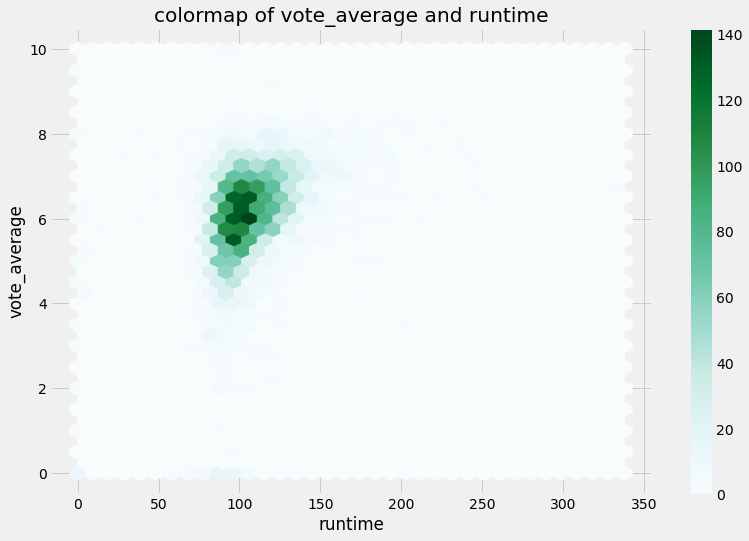

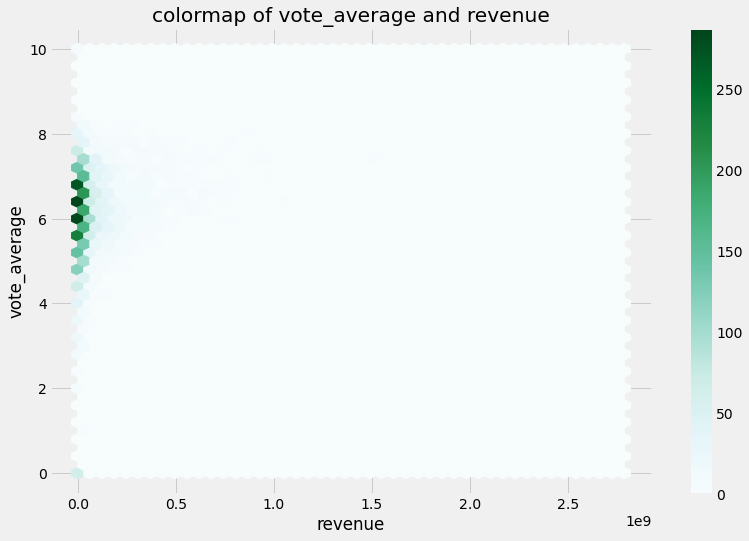

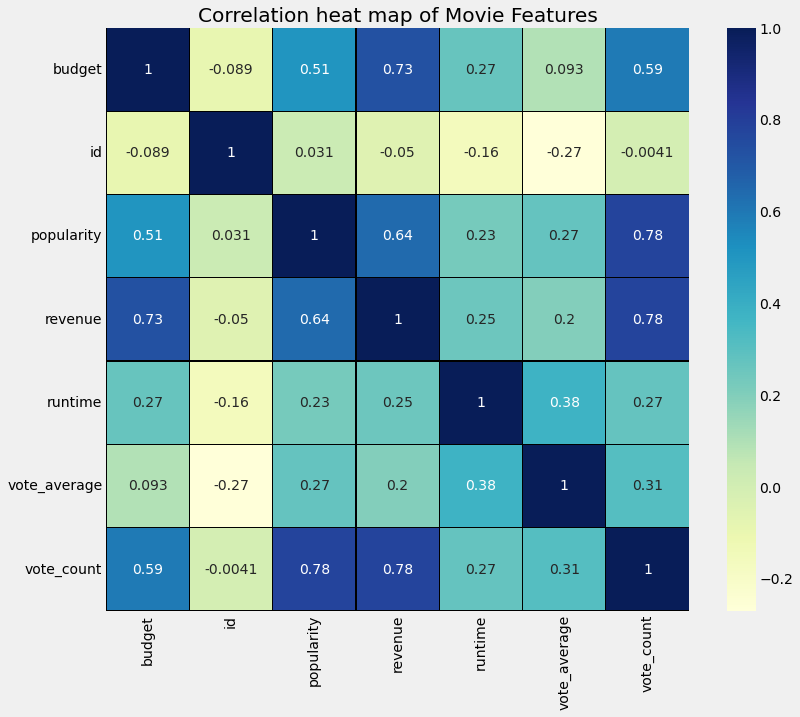

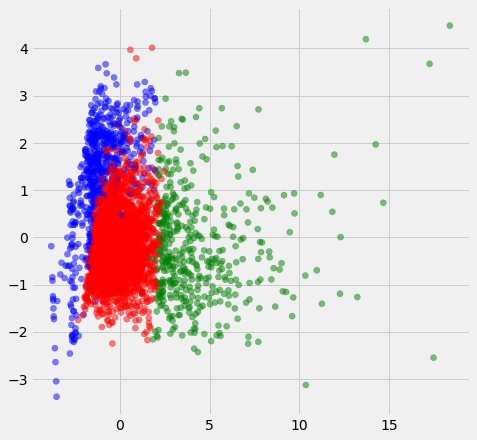

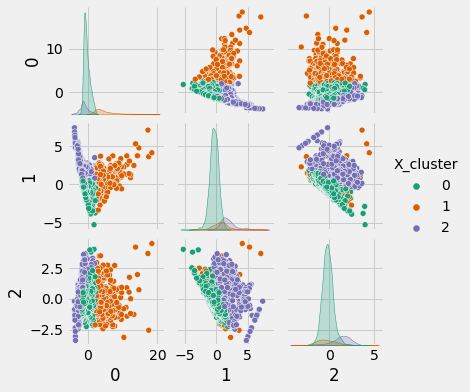

In [ ]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

movie =pd.read_csv('tmdb_5000_movies.csv')
credit =pd.read_csv('tmdb_5000_credits.csv')

# empty list to contain columns with strings
str_list = [] 
for colname, colvalue in movie.iteritems():
    if type(colvalue[1]) == str:
        str_list.append(colname)

#Get to the numeric columns by inversion
num_list = movie.columns.difference(str_list)

movie_num = movie[num_list]
movie_num.head()

movie_num = movie_num.fillna(value=0, axis=1)

# standardize data
X = movie_num.values
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

list(movie)

# visualize color map
movie.plot(y = 'vote_average', x = 'runtime', kind = 'hexbin', gridsize=35, sharex=False, 
           colormap='', title='colormap of vote_average and runtime',figsize=(12,8))
movie.plot(y ='vote_average', x = 'revenue', kind='hexbin', gridsize = 45, sharex = False,
          colormap = '', title='colormap of vote_average and revenue', figsize = (12,8))

#  generate heat map
f, ax = plt.subplots(figsize=(12,10))
plt.title('Correlation heat map of Movie Features')
sns.heatmap(movie_num.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,  
            cmap="YlGnBu", linecolor='black', annot=True)


X = movie_num.values
# Data Normalization
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=7)
x_7d = pca.fit_transform(X_std)

pca4 = PCA(n_components=4)
x_4d = pca.fit_transform(X_std)

#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_7d)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_7d[:,0],x_7d[:,2], c= label_color, alpha=0.5) 
plt.show()


# Create a temp dataframe from our PCA projection data "x_9d"
df = pd.DataFrame(x_4d)

# only visualise relationships between first 3 projections
df = df[[0,1,2]] 
df['X_cluster'] = X_clustered

# Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

In [ ]:
#Content Based Filtering

import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies =pd.read_csv('tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

movies_df = movies[['id','title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

pd.set_option('max_colwidth', 100)
movies_df[['genres','keywords']][:1]

# make a string a list[dict1,dict2] object that the string means
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

# Find values that correspond to multiple dictionary 'name' keys in the list with 
# for loop and convert them into list objects
movies_df['genres'] = movies_df['genres'].apply(lambda x : [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]


from sklearn.feature_extraction.text import CountVectorizer

# convert to a string with word units separated by blank characters to apply CountVectorizer, 
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)


from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])


genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])


def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    
    # Extract DataFrame, the title_name value entered in the 'title' column
    title_movie = df[df['title'] == title_name]
    
    # Return index object of DataFrame with title_named to ndarray
    # Extract top_n indexes in order of similarity from genre_sim_sorted_ind object entered with sorted_ind factor
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]
    
    # Output of the extracted top_n indexes
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]


similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average']]

movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]


C = movies_df['vote_average'].mean()
# Extract top 60% value using Series object quantile()
m = movies_df['vote_count'].quantile(0.6)  
print('C: ',round(C,3), 'm: ',round(m,3))

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )  


movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1)
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote', ascending=False)[:10]


def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    
    # Extracting an index with high zangir similarity equivalent to twice the top_n
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)

    # Excluding reference movie index
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    # Extract top_n from the candidate group twice the top_n in the order of weighted_vote 
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

(4803, 20)
(4803, 276)
(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]
[[   0 3494  813 ... 3038 3037 2401]]
[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]
C:  6.092 m:  370.2


,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


In [ ]:
# Collaborative based Filtering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

movies = pd.read_csv('tmdb_5000_movies.csv', index_col=0)
credit = pd.read_csv('tmdb_5000_credits.csv')

credit_renamed = credit.rename(columns ={"movie_id":"id"})
credit_renamed

# Merging of two datsets with common column
movies_new = movies.merge(credit_renamed, on = 'id')
movies_new.head()

movies_new.info()

# Drop the unneccessary columns of merged data set of movies
movies_updated = movies_new.drop(columns = ['homepage','overview','title_x','title_y','status','production_countries', 'cast','crew','tagline', 'status', 'spoken_languages', 'revenue', 'runtime', 'release_date', 'production_companies', 'keywords', 'original_language'])
movies_updated.head(20)

movies_updated.shape
movies_updated.info()

movies_updated[['id','original_title','popularity','vote_average','vote_count','genres']]

# Generating Movie weightage based on users rating and no. of views of movies
# W = (Rv + Cm) / (v + m)
v = movies_updated['vote_count']
R = movies_updated['vote_average']
C = movies_updated['vote_average'].mean()
m = movies_updated['vote_count'].quantile(0.70)

movies_updated.head()

# Dropping Genere Column of movie weightage data set
Movies_viewers = movies_updated.drop(['genres'], axis=1)
Movies_viewers

movies_vote_avg = Movies_viewers.sort_values('vote_average',ascending=False)
movies_vote_avg

# Sorting movies based on popularity and weightage data set
Movies_popular = Movies_viewers.sort_values('popularity', ascending=False).reset_index()
Movies_popular

# Deleting column from the popular movies data set
Popular_movies = pd.DataFrame(Movies_popular, columns=['index','original_title'])
Popular_movies

# Collaborative Movies recommended based on criteria 50% of popular movies and 50% voted averaged movies
from sklearn.preprocessing import MinMaxScaler
scaling=MinMaxScaler()
Movies_scaled = scaling.fit_transform(movies_vote_avg[['vote_average', 'popularity']])
Movies_norm = pd.DataFrame(Movies_scaled, columns=['vote_average','popularity'])
Movies_norm.head()

Movies_norm_rename = {Movies_norm.columns[0]:'Voted_avg_norm', Movies_norm.columns[1]: 'Popularity_norm'}
Movies_norm = Movies_norm.rename(columns=Movies_norm_rename).round(4)
Movies_norm

# Sorting the movie weightage data set based on voted average
movies_vote_avg = Movies_viewers.sort_values('vote_average',ascending=False)
movies_vote_avg

# Concatenate the movies data set with normalized voted average and popularity 
Movies_combine = pd.concat([movies_vote_avg, Movies_norm], axis=1)
Movies_combine

# Generating scores and sorting it based on the criteria set in the starting
Movies_combine['score']=Movies_combine['Voted_avg_norm']*0.5 + Movies_combine['Popularity_norm']*0.5
Movies_combine

Movies_recbycol = Movies_combine.sort_values(by="score", ascending=False).round(4)
Movies_recbycol[['original_title','Voted_avg_norm','Popularity_norm','score']].head(25).reset_index()

# Movies_Collaborative = Movies_combine['original_title'].head(20)
# Movies_Rec_Collaborative = pd.DataFrame(Movies_Collaborative, columns=['index','original_title'])
# Movies_Rec_Collaborative

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genres                4803 non-null   object 
 1   homepage              1712 non-null   object 
 2   id                    4803 non-null   int64  
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   original_title        4803 non-null   object 
 6   overview              4800 non-null   object 
 7   popularity            4803 non-null   float64
 8   production_companies  4803 non-null   object 
 9   production_countries  4803 non-null   object 
 10  release_date          4802 non-null   object 
 11  revenue               4803 non-null   int64  
 12  runtime               4801 non-null   float64
 13  spoken_languages      4803 non-null   object 
 14  status                4803 non-null   object 
 15  tagline              

,index,original_title,Voted_avg_norm,Popularity_norm,score
0,2121,Max,0.64,1.0000,0.8200
1,36,Transformers: Age of Extinction,0.81,0.8272,0.8186
2,112,Alexander,0.79,0.5495,0.6698
3,346,What Lies Beneath,0.74,0.5877,0.6639
4,676,Wyatt Earp,0.72,0.4960,0.6080
5,1876,Bride of Chucky,0.65,0.4782,0.5641
6,311,The Adventures of Pluto Nash,0.75,0.3106,0.5303
7,11,Quantum of Solace,0.83,0.2199,0.5250
8,18,Men in Black 3,0.82,0.2139,0.5170
9,133,Dark Shadows,0.78,0.2327,0.5064


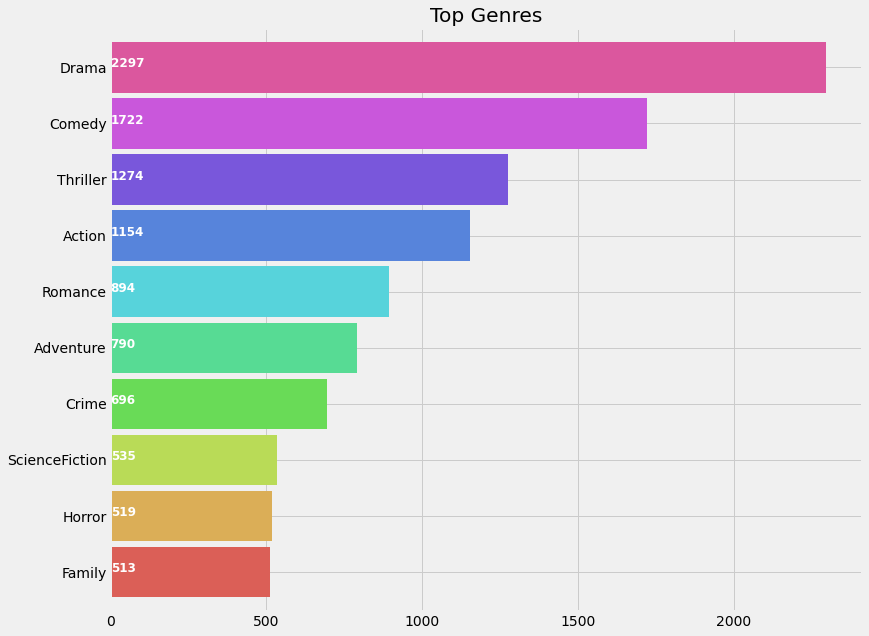

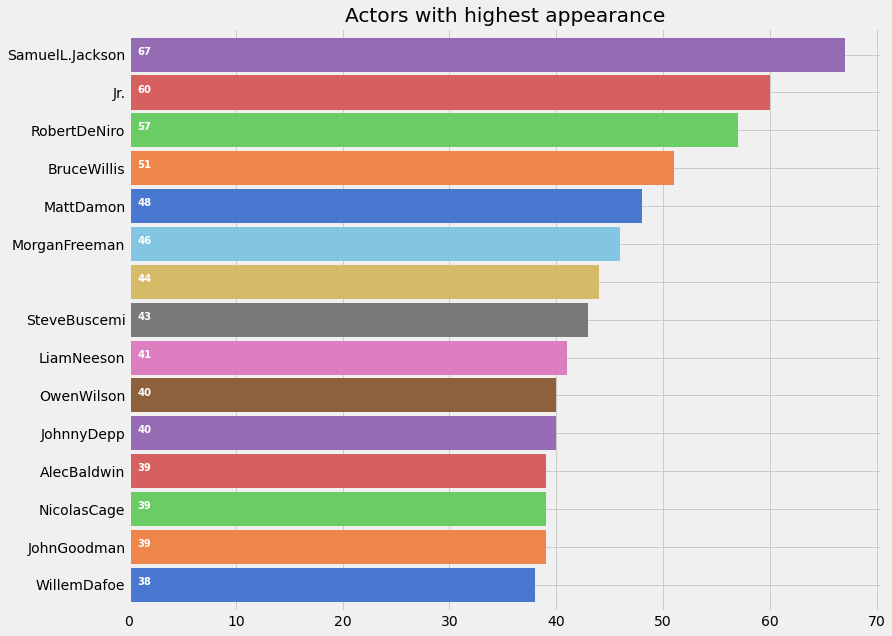

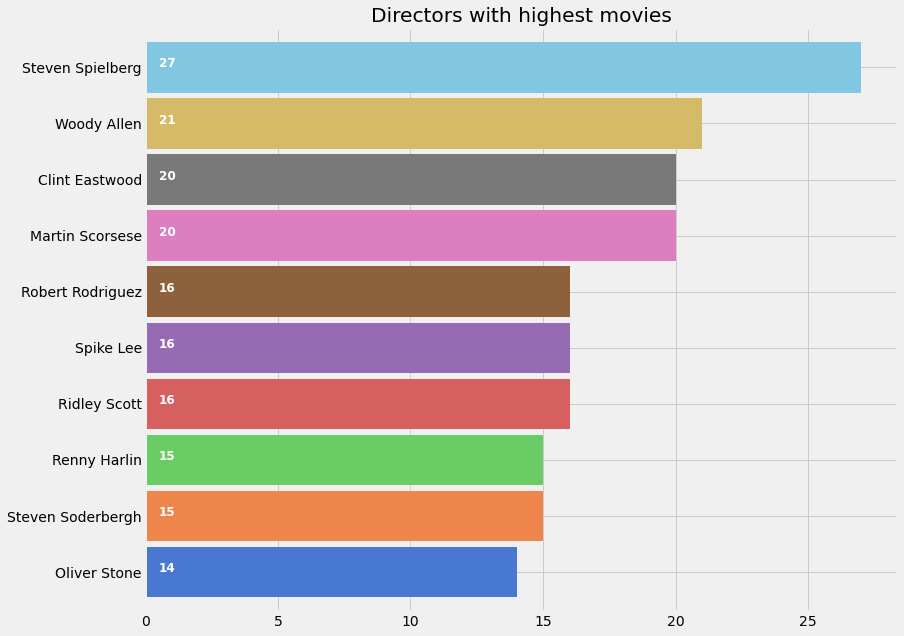

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


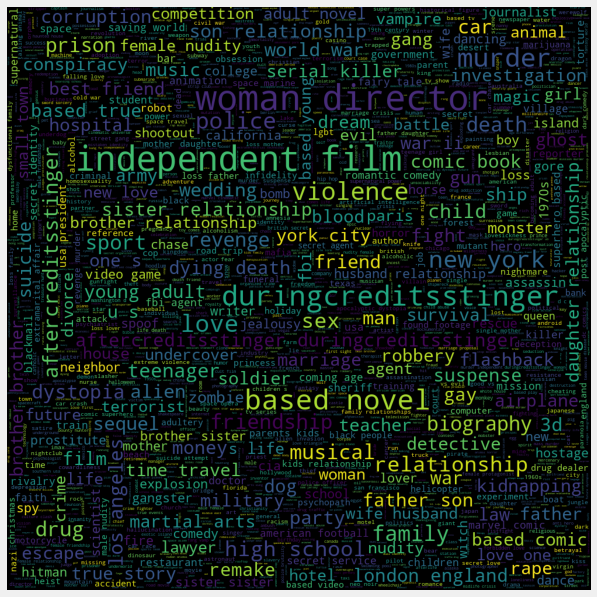

id                                                            49026
original_title                                The Dark Knight Rises
genres                             [Action, Crime, Drama, Thriller]
cast              AnneHathaway,ChristianBale,GaryOldman,MichaelC...
vote_average                                                    7.6
director                                          Christopher Nolan
keywords          [batman, burglar, catburglar, catwoman, cover-...
genres_bin        [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
cast_bin          [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...
director_bin      [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
words_bin         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 3, dtype: object
id                                                            82702
original_title                           How to Train Your Dragon 2
genres            [Action, Adventure, Animation, Comedy, Family,...
cast                 Gera

In [ ]:
# KNN

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
from matplotlib.pyplot import imread
import codecs
from IPython.display import HTML

movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

# Convert JSON into strings
# changing the genres column from json to string
movies['genres'] = movies['genres'].apply(json.loads)
for index,i in zip(movies.index,movies['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    movies.loc[index,'genres'] = str(list1)

# changing the keywords column from json to string
movies['keywords'] = movies['keywords'].apply(json.loads)
for index,i in zip(movies.index,movies['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'keywords'] = str(list1)
    
# changing the production_companies column from json to string
movies['production_companies'] = movies['production_companies'].apply(json.loads)
for index,i in zip(movies.index,movies['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_companies'] = str(list1)

# changing the cast column from json to string
credits['cast'] = credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast'] = str(list1)

# changing the crew column from json to string    
credits['crew'] = credits['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
credits['crew'] = credits['crew'].apply(director)
credits.rename(columns={'crew':'director'},inplace=True)

movies.iloc[25]

# Merge the two csv files
movies = movies.merge(credits,left_on='id',right_on='movie_id',how='left')
movies = movies[['id','original_title','genres','cast','vote_average','director','keywords']]

movies.iloc[25]
movies.shape
movies.size
movies.index
movies.columns
movies.dtypes


movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

plt.subplots(figsize=(12,10))
list1 = []
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()


for i,j in zip(movies['genres'],movies.index):
    list2=[]
    list2=i
    list2.sort()
    movies.loc[j,'genres']=str(list2)


# Work with the Genres column
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

genreList = []
for index, row in movies.iterrows():
    genres = row["genres"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #now we have a list with unique genres


def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList


movies['genres_bin'] = movies['genres'].apply(lambda x: binary(x))
movies['genres_bin'].head()


# Work with the Cast Column
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['cast'] = movies['cast'].str.split(',')

plt.subplots(figsize=(12,10))
list1=[]
for i in movies['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()


for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i[:4]
    movies.loc[j,'cast'] = str(list2)
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['cast'] = movies['cast'].str.split(',')
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'cast'] = str(list2)
movies['cast']=movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')

castList = []
for index, row in movies.iterrows():
    cast = row["cast"]
    
    for i in cast:
        if i not in castList:
            castList.append(i)

def binary(cast_list):
    binaryList = []
    
    for genre in castList:
        if genre in cast_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList


movies['cast_bin'] = movies['cast'].apply(lambda x: binary(x))
movies['cast_bin'].head()


# Work with Director column
def xstr(s):
    if s is None:
        return ''
    return str(s)
movies['director'] = movies['director'].apply(xstr)


plt.subplots(figsize=(12,10))
ax = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()


directorList=[]
for i in movies['director']:
    if i not in directorList:
        directorList.append(i)

def binary(director_list):
    binaryList = []  
    for direct in directorList:
        if direct in director_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

movies['director_bin'] = movies['director'].apply(lambda x: binary(x))
movies.head()   


# Work with the Keywords column
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')

plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

words=movies['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()


movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')


words_list = []
for index, row in movies.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)

def binary(words):
    binaryList = []
    for genre in words_list:
        if genre in words:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

movies['words_bin'] = movies['keywords'].apply(lambda x: binary(x))
movies = movies[(movies['vote_average']!=0)] #removing the movies with 0 score and without drector names 
movies = movies[movies['director']!='']

# Similarity between movies
from scipy import spatial

def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['cast_bin']
    scoreB = b['cast_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['words_bin']
    wordsB = b['words_bin']
    wordsDistance = spatial.distance.cosine(directA, directB)
    return genreDistance + directDistance + scoreDistance + wordsDistance

#checking similarity between any 2 random movies
Similarity(3,160)

print(movies.iloc[3])
print(movies.iloc[160])

new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','director','director_bin','words_bin']]
movies.head()


# Predicting Score 
import operator

def predict_score(name):
    #name = input('Enter a movie title: ')
    new_movie = movies[movies['original_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.original_title.values[0])
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)
    
    print('\nRecommended Movies: \n')
    for neighbor in neighbors:
        avgRating = avgRating+movies.iloc[neighbor[0]][2]  
        print( movies.iloc[neighbor[0]][0]+
              " | Genres: "+str(movies.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+
              " | Rating: "+str(movies.iloc[neighbor[0]][2]))
    
    print('\n')
    avgRating = avgRating/K
    print('The predicted rating for %s is: %f' %(new_movie['original_title'].values[0],avgRating))
    print('The actual rating for %s is %f' %(new_movie['original_title'].values[0],new_movie['vote_average']))

predict_score('Godfather')   